In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input




/Users/user/repos/tbilisi_home_price_prediction_model/pricing_model/env/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
%matplotlib inline


In [3]:
path_to_csv = "../data/housing_data.csv"
image_dir = "../data/images/" 
column_names = ["id", "url", "imageurl", "header", "price", "sqmprice", "sqm", "floor", "rooms", "bedrooms", "address"]


In [4]:
df = pd.read_csv(path_to_csv, names=column_names, header=None)
image_files = set(os.listdir(image_dir))
valid_ids = {int(filename.split('.')[0]) for filename in image_files if filename.split('.')[0].isdigit()}
df = df[df.iloc[:, 0].isin(valid_ids)]
df = df.dropna() # We lost 5% of the data, problem seems to be with the method of scraping or the website error itself
df.drop(['url', 'imageurl'], axis=1, inplace=True)

In [5]:
def modify_address(addr):
    # Split the address string by comma and retain everything after the first comma
    parts = addr.split(',', 1)  # Split only at the first comma
    return parts[1].strip() if len(parts) > 1 else addr

In [6]:
mask = df["address"].isin(df["address"].value_counts()[df["address"].value_counts() < 30].index)

# Filter the dataframe using the mask
df.loc[mask, 'address'] = df.loc[mask, 'address'].apply(modify_address)
df['address'] = df['address'].str.replace(', ', '', regex=True)
mask = df["address"].isin(df["address"].value_counts()[df["address"].value_counts() < 30].index)

df.loc[mask, 'address'] = df.loc[mask, 'address'].apply(modify_address)

mask = df["address"].isin(df["address"].value_counts()[df["address"].value_counts() > 40].index)

df = df[mask]

In [7]:
df['address'] = df['address'].str.replace(', ', '', regex=True)

In [8]:
df[df['address'].str.startswith('')]

,id,header,price,sqmprice,sqm,floor,rooms,bedrooms,address
0,0,იყიდება ახალი აშენებული ბინა მთაწმინდაზე,"210,000",3134.0,67.00 მ²,სარ. 5,ოთ. 3,საძ. 2,მთაწმინდამთაწმინდის რაიონითბილისი
1,1,იყიდება ძველი აშენებული ბინა დიდუბეში,"185,000",1595.0,116.00 მ²,სარ. 4,ოთ. 5,საძ. 4,ა. წერეთლის გამზირიდიდუბედიდუბის რაიონითბილისი
3,3,იყიდება ახალი აშენებული ბინა ორთაჭალაში,"138,000",1917.0,72.00 მ²,სარ. 7,ოთ. 3,საძ. 2,ვ. გორგასლის ქუჩაორთაჭალაკრწანისის რაიონითბილისი
5,5,იყიდება ახალი აშენებული ბინა დიდ დიღომში,"60,000",1200.0,50.00 მ²,სარ. 2,ოთ. 2,საძ. 1,დიდი დიღომისაბურთალოს რაიონითბილისი
6,6,იყიდება ძველი აშენებული ბინა ვაზისუბანში,"55,000",833.0,66.00 მ²,სარ. 5,ოთ. 3,საძ. 2,შ. პეტეფის ქუჩავაზისუბანიისნის რაიონითბილისი
...,...,...,...,...,...,...,...,...,...
63091,63093,იყიდება ახალი აშენებული ბინა ვარკეთილის მასივი...,"78,000",975.0,80.00 მ²,სარ. 6,ოთ. 3,საძ. 2,ვარკეთილის მასივი IIIვარკეთილი-3 III მ/რვარკეთ...
63092,63094,იყიდება ახალი აშენებული ბინა საბურთალოზე,"180,000",1385.0,130.00 მ²,სარ. 7,ოთ. 4,საძ. 3,ს. ჩიქოვანის ქუჩასაბურთალოსაბურთალოს რაიონითბი...
63093,63095,იყიდება ახალი აშენებული ბინა საბურთალოზე,"89,000",1935.0,46.00 მ²,სარ. 17,ოთ. 2,საძ. 1,ბერბუკის ქუჩასაბურთალოსაბურთალოს რაიონითბილისი
63094,63096,იყიდება ახალი აშენებული ბინა ნაძალადევში,"85,000",1700.0,50.00 მ²,სარ. 2,ოთ. 2,საძ. 1,ც. დადიანის ქუჩანაძალადევინაძალადევის რაიონითბ...


In [9]:
df["address"].value_counts()

address
დიდი დიღომისაბურთალოს რაიონითბილისი                                             1830
ა. პოლიტკოვსკაიას ქუჩა (ჯიქია)საბურთალოსაბურთალოს რაიონითბილისი                 1707
საბურთალოსაბურთალოს რაიონითბილისი                                               1668
ი. ჭავჭავაძის გამზირივაკევაკის რაიონითბილისი                                    1206
ვაკევაკის რაიონითბილისი                                                          964
                                                                                ... 
როსტევანის ქუჩადიდი დიღომისაბურთალოს რაიონითბილისი                                42
ი. მოსაშვილის ქუჩავაკევაკის რაიონითბილისი                                         42
ვაჟა-ფშაველას I კვ.ვაჟა-ფშაველას კვარტალებისაბურთალოსაბურთალოს რაიონითბილისი      42
ლიბანის ქუჩაავჭალაგლდანის რაიონითბილისი                                           41
მ. ბუხაიძის ქუჩავორონცოვიჩუღურეთის რაიონითბილისი                                  41
Name: count, Length: 269, dtype: int64

In [10]:
df['status'] = df['header'].str.split().str.get(1)
df['location_name'] = df['header'].str.replace("იყიდება ახალი აშენებული ბინა ", "", regex=False).str.strip()
df['location_name'] = df['location_name'].str.replace("იყიდება ძველი აშენებული ბინა ", "", regex=False).str.strip()
df['location_name'] = df['location_name'].str.replace("იყიდება მშენებარე ბინა ", "", regex=False).str.strip()

value_counts = df['location_name'].value_counts()
print(value_counts)
# Keep only rows where the 'location_name' value count is >= 30
df = df[df['location_name'].isin(value_counts[value_counts >= 30].index)]
df.drop(['header'], axis=1, inplace=True)


location_name
საბურთალოზე        11556
ვაკეში              4827
დიდ დიღომში         3381
დიდუბეში            2386
გლდანის მასივში     2247
                   ...  
ფონიჭალაში             1
ივერთუბანში            1
ლოტკინზე               1
ორხევში                1
ახალდაბაში             1
Name: count, Length: 109, dtype: int64


In [11]:
df["price"] = df["price"].str.replace(",", "").astype(float)
df["sqm"] = df["sqm"].str.replace(" მ²", "").astype(float)
df["floor"] = df["floor"].str.replace("სარ.", "").astype(float)
df["rooms"] = df["rooms"].str.replace("ოთ.", "").astype(float)
df["bedrooms"] = df["bedrooms"].str.replace("საძ.", "").astype(float)
df.drop("sqmprice", axis=1, inplace=True)
df.drop("id", axis=1, inplace=True)



In [12]:
df.sort_values(by='price', ascending=True)

,price,sqm,floor,rooms,bedrooms,address,status,location_name
12625,12800.0,44.9,12.0,2.0,1.0,მირიან მეფის ქუჩადიდი დიღომისაბურთალოს რაიონით...,მშენებარე,დიდ დიღომში
22055,13000.0,13.0,1.0,1.0,1.0,ვაჟა-ფშაველას კვარტალებისაბურთალოსაბურთალოს რა...,ახალი,ვაჟა-ფშაველას კვარტალებში
40403,14000.0,34.0,1.0,3.0,1.0,გლდანი 1 მკრ.გლდანის მასივიგლდანის რაიონითბილისი,ახალი,გლდანი 1 მკრ. რაიონში
52772,14500.0,43.2,2.0,2.0,1.0,მირიან მეფის ქუჩადიდი დიღომისაბურთალოს რაიონით...,მშენებარე,დიდ დიღომში
16714,15000.0,8.9,1.0,1.0,1.0,სოლოლაკიმთაწმინდის რაიონითბილისი,ძველი,სოლოლაკში
...,...,...,...,...,...,...,...,...
16671,13950000.0,90.0,1.0,3.0,2.0,საბურთალოსაბურთალოს რაიონითბილისი,ახალი,საბურთალოზე
3467,16200000.0,108.0,2.0,3.0,2.0,ა. პოლიტკოვსკაიას ქუჩა (ჯიქია)საბურთალოსაბურთა...,ახალი,საბურთალოზე
18797,32400000.0,120.0,4.0,3.0,2.0,ვაკევაკის რაიონითბილისი,ახალი,ვაკეში
15287,100000000.0,251.0,2.0,7.0,5.0,ვერამთაწმინდის რაიონითბილისი,ძველი,ვერაზე


In [13]:
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
print(f"Number of jpg images in {image_dir}: {len(image_files)}")


Number of jpg images in ../data/images/: 57837


In [14]:
df = df[df["price"] <= 500000]
df = df[df["price"] >= 10000]


In [15]:
scaler = MinMaxScaler()
price_scaler = MinMaxScaler()
df[['sqm', 'floor', 'rooms', 'bedrooms']] = scaler.fit_transform(df[['sqm', 'floor', 'rooms', 'bedrooms']])
df[['price']] = price_scaler.fit_transform(df[['price']])

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=['location_name', "status", "address"])

bool_cols = [col for col in df.columns if df[col].dtype == 'bool']
df[bool_cols] = df[bool_cols].astype(int)
# Split the data into training and test sets
y = df['price']
X = df.drop('price', axis=1)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [16]:

# Input layer
input_layer = Input(shape=(X_train.shape[1],))

# First Dense and BatchNormalization layers
x = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(input_layer)
x = layers.BatchNormalization()(x)

# Second Dense and BatchNormalization layers
x = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)

# Third Dense and BatchNormalization layers
x = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)

# Fourth Dense and BatchNormalization layers
x = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)

# Fifth Dense layer
x = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(x)

# Output layer
output_layer = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs=input_layer, outputs=output_layer)


In [17]:
model.compile(optimizer=keras.optimizers.legacy.Adam(0.001), loss='mean_squared_error',  metrics=['mean_absolute_error'])

In [30]:
#Train for approx 300 epochs
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_dev, y_dev))

Epoch 1/100
324/324 [==============================] - 3s 8ms/step - loss: 8.8884e-04 - mean_absolute_error: 0.0177 - val_loss: 0.0029 - val_mean_absolute_error: 0.0262
Epoch 2/100
324/324 [==============================] - 3s 10ms/step - loss: 9.0002e-04 - mean_absolute_error: 0.0180 - val_loss: 0.0029 - val_mean_absolute_error: 0.0267
Epoch 3/100
324/324 [==============================] - 4s 14ms/step - loss: 9.0707e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0029 - val_mean_absolute_error: 0.0263
Epoch 4/100
324/324 [==============================] - 4s 11ms/step - loss: 9.0283e-04 - mean_absolute_error: 0.0180 - val_loss: 0.0028 - val_mean_absolute_error: 0.0259
Epoch 5/100
324/324 [==============================] - 3s 11ms/step - loss: 9.0034e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0028 - val_mean_absolute_error: 0.0255
Epoch 6/100
324/324 [==============================] - 3s 10ms/step - loss: 9.3933e-04 - mean_absolute_error: 0.0181 - val_loss: 0.0028 - val_mean_abso

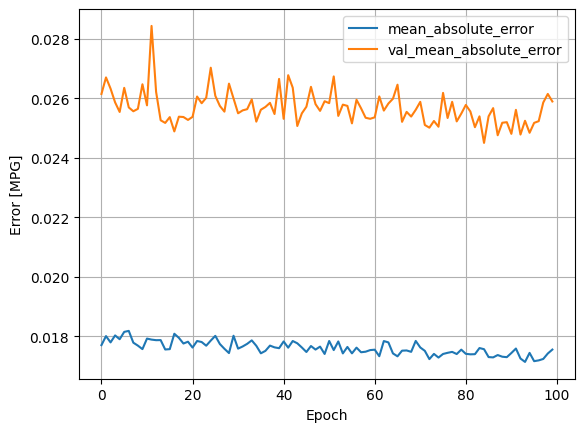

In [31]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
def plot_mae(history):
  plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
  plt.plot(history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)  
#plot_loss(history)
plot_mae(history)

In [32]:
loss, mae = model.evaluate(X_dev, y_dev)
train_loss, train_mae = model.evaluate(X_train, y_train)

print(f"Test Loss: {loss}")
scaled_mae = mae
scaled_train_mae = train_mae
original_mae = scaled_mae * (price_scaler.data_max_ - price_scaler.data_min_)
original_train_mae = scaled_train_mae * (price_scaler.data_max_ - price_scaler.data_min_)

print(f"Original MAE: {original_mae[0]}")
print(f"Original train MAE: {original_train_mae[0]}")

1296/1296 [==============================] - 3s 2ms/step - loss: 7.0662e-04 - mean_absolute_error: 0.0154
Test Loss: 0.002750743180513382
Original MAE: 12617.685391008854
Original train MAE: 7481.795552372932


In [21]:
# 1. Predict on test data
y_pred = model.predict(X_dev)

# Inverse transform the scaled target variable (y_dev)
y_dev_actual = price_scaler.inverse_transform(y_dev.values.reshape(-1, 1))

# Inverse transform the scaled predictions (y_pred)
y_pred_actual = price_scaler.inverse_transform(y_pred.reshape(-1, 1))

print(y_dev_actual.shape)
print(y_pred_actual.shape)

# 2. Create a DataFrame with actual and predicted values
comparison_df = pd.DataFrame({
    'Actual Values': y_dev_actual.flatten(),
    'Predicted Values': y_pred_actual.flatten() # flatten is used to convert the 2D array to 1D
})

print(comparison_df)


162/162 [==============================] - 0s 851us/step
(5182, 1)
(5182, 1)
      Actual Values  Predicted Values
0           39000.0      43962.246094
1           85000.0      89542.523438
2           47000.0      46183.253906
3          112000.0      99697.976562
4           85000.0      87257.101562
...             ...               ...
5177       230000.0     235328.125000
5178        76000.0      66586.617188
5179       136000.0     132147.750000
5180        68400.0      52171.246094
5181       488000.0     409492.312500

[5182 rows x 2 columns]


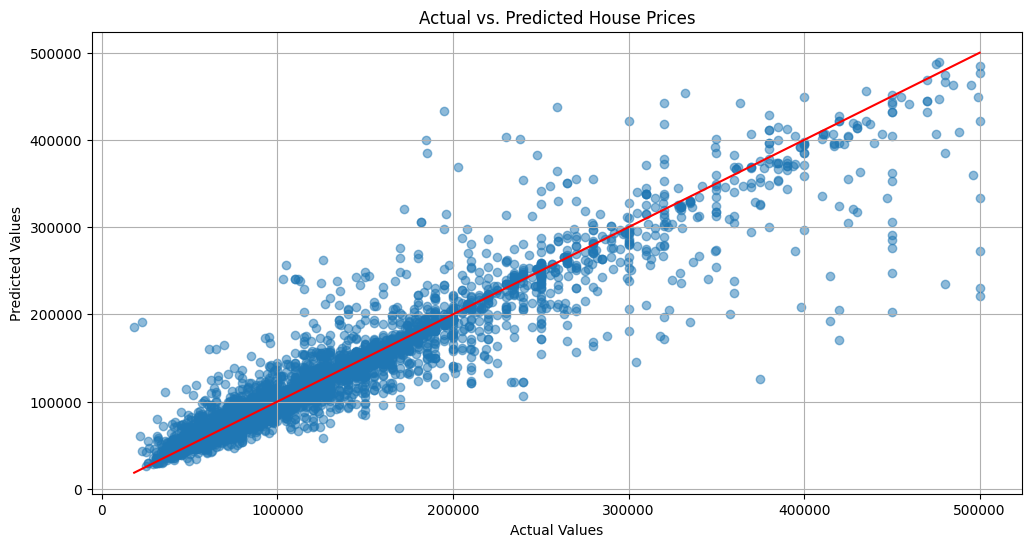

In [22]:
import matplotlib.pyplot as plt

# Scatter plot of Actual vs. Predicted values
plt.figure(figsize=(12, 6))

# Scatter plot
plt.scatter(comparison_df['Actual Values'], comparison_df['Predicted Values'], alpha=0.5)
plt.plot([min(comparison_df['Actual Values']), max(comparison_df['Actual Values'])], 
         [min(comparison_df['Actual Values']), max(comparison_df['Actual Values'])], 
         color='red')  # Diagonal line

plt.title('Actual vs. Predicted House Prices')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


In [23]:
y_pred_test = model.predict(X_dev)
y_dev_actual_for_r2 = price_scaler.inverse_transform(y_dev.values.reshape(-1, 1))
y_pred_actual_for_r2 = price_scaler.inverse_transform(y_pred_test.reshape(-1, 1))

# Calculate the R^2 score
r2 = r2_score(y_dev_actual_for_r2, y_pred_actual_for_r2)
r2

162/162 [==============================] - 0s 869us/step


0.8916145502257553

In [35]:
test_loss, test_mae = model.evaluate(X_test, y_test)
original_test_mae = test_mae * (price_scaler.data_max_ - price_scaler.data_min_)

print(f"Original test MAE: {original_mae[0]}")


162/162 [==============================] - 0s 1ms/step - loss: 0.0033 - mean_absolute_error: 0.0273
Original test MAE: 12617.685391008854


The results are not great they are off by more than 12k which is a significant amount for house prices. Most probable reason is lack of features which will allow model to capture larger variance